In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>\n{css}\n</style>"))


# Chapter 1 — Introduction to Machine Learning
# Lesson 3: Applications and Real-World Use Cases

This lesson focuses on how machine learning is used in practice: what problems it solves, how to translate business/engineering needs into ML tasks, and how to evaluate success beyond a single metric. You will build and evaluate several small, end‑to‑end examples across **classification**, **regression**, and **clustering**, using datasets from this repository.

## Learning objectives

By the end of this lesson, you should be able to:

- Identify common real‑world ML use cases and map them to tasks (classification, regression, ranking, clustering, anomaly detection, forecasting).
- Translate a high‑level question into: data requirements, target definition, constraints, and a measurable notion of success.
- Build baseline models quickly and evaluate them with appropriate metrics and cost considerations.
- Recognize practical issues (data leakage, drift, calibration, monitoring, governance) that affect production performance.

## Notation (minimal)

- Data: $X \in \mathbb{R}^{n \times d}$, targets $y$ (labels).
- Model: $f_\theta(x)$ with parameters $\theta$.
- Loss: $\ell(y, \hat{y})$.
- **Expected risk** (what we wish to minimize):  
  $$R(f) = \mathbb{E}[\ell(y, f(x))]$$
- **Empirical risk** (what we can compute on samples):  
  $$\hat{R}(f) = \frac{1}{n}\sum_{i=1}^{n}\ell(y_i, f(x_i))$$

We will rely on practical implementations in `pandas` and `scikit-learn` and emphasize **reproducible baselines**.

---


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO
from IPython.display import display

# Reproducibility (deterministic demos)
SEED = 42
rng = np.random.default_rng(SEED)

def load_csv(path: str, fallback_csv: str) -> pd.DataFrame:
    """
    Load a CSV from a relative repo path. If the file is not present
    (e.g., when running this notebook outside the repo), fall back to
    an embedded sample constructed from the dataset's top rows.
    """
    p = Path(path)
    if p.exists():
        df = pd.read_csv(p)
        source = f"Loaded from file: {path}"
    else:
        df = pd.read_csv(StringIO(fallback_csv.strip()))
        source = "Loaded from embedded sample (file not found in this runtime)"
    print(source)
    return df

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [3]:
fallback_map = {
    "../../../Datasets/Classification/diabetes.csv": "Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification\n6,148,72,35,0,33.6,0.627,50,Diabetic\n1,85,66,29,0,26.6,0.351,31,Non-Diabetic\n8,183,64,0,0,23.3,0.672,32,Diabetic\n1,89,66,23,94,28.1,0.167,21,Non-Diabetic\n0,137,40,35,168,43.1,2.288,33,Diabetic\n",
    "../../../Datasets/Classification/iris.csv": "sepal_length,sepal_width,petal_length,petal_width,classification\n5.4,3.7,1.5,0.2,Iris-setosa\n4.8,3.4,1.6,0.2,Iris-setosa\n4.8,3,1.4,0.1,Iris-setosa\n4.3,3,1.1,0.1,Iris-setosa\n5.8,4,1.2,0.2,Iris-setosa\n",
    "../../../Datasets/Classification/drug200.csv": "Age,Sex,BP,Cholesterol,Na_to_K,Drug\n23,F,HIGH,HIGH,25.355,DrugY\n47,M,LOW,HIGH,13.093,drugC\n47,M,LOW,HIGH,10.114,drugC\n28,F,NORMAL,HIGH,7.798,drugX\n61,F,LOW,HIGH,18.043,DrugY\n22,F,NORMAL,HIGH,8.607,drugX\n",
    "../../../Datasets/Clustering/airports.csv": "\"id\",\"ident\",\"type\",\"name\",\"latitude_deg\",\"longitude_deg\",\"elevation_ft\",\"continent\",\"iso_country\",\"iso_region\",\"municipality\",\"scheduled_service\",\"icao_code\",\"iata_code\",\"gps_code\",\"local_code\",\"home_link\",\"wikipedia_link\",\"keywords\"\n6523,\"00A\",\"heliport\",\"Total RF Heliport\",40.070985,-74.933689,11,\"NA\",\"US\",\"US-PA\",\"Bensalem\",\"no\",,,\"K00A\",\"00A\",\"https://www.penndot.pa.gov/TravelInPA/airports-pa/Pages/Total-RF-Heliport.aspx\",,\n323361,\"00AA\",\"small_airport\",\"Aero B Ranch Airport\",38.704022,-101.473911,3435,\"NA\",\"US\",\"US-KS\",\"Leoti\",\"no\",,,\"00AA\",\"00AA\",,,\n6524,\"00AK\",\"small_airport\",\"Lowell Field\",59.947733,-151.692524,450,\"NA\",\"US\",\"US-AK\",\"Anchor Point\",\"no\",,,\"00AK\",\"00AK\",,,\n6525,\"00AL\",\"small_airport\",\"Epps Airpark\",34.86479949951172,-86.77030181884766,820,\"NA\",\"US\",\"US-AL\",\"Harvest\",\"no\",,,\"00AL\",\"00AL\",,,\n506791,\"00AN\",\"small_airport\",\"Katmai Lodge Airport\",59.093287,-156.456699,80,\"NA\",\"US\",\"US-AK\",\"King Salmon\",\"no\",,,\"00AN\",\"00AN\",,,\n322127,\"00AS\",\"small_airport\",\"Fulton Airport\",34.9428028,-97.8180194,1100,\"NA\",\"US\",\"US-OK\",\"Alex\",\"no\",,,\"00AS\",\"00AS\",,,\n",
    "../../../Datasets/Clustering/hw_200.csv": "\"Index\", Height(Inches)\", \"Weight(Pounds)\"\n1, 65.78, 112.99\n2, 71.52, 136.49\n3, 69.40, 153.03\n4, 68.22, 142.34\n5, 67.79, 144.30\n6, 68.70, 123.30\n",
    "../../../Datasets/Clustering/ConsumerComplaints.csv": "Date Received,Product Name,Sub Product,Issue,Sub Issue,Consumer Complaint Narrative,Company Public Response,Company,State Name,Zip Code,Tags,Consumer Consent Provided,Submitted via,Date Sent to Company,Company Response to Consumer,Timely Response,Consumer Disputed,Complaint ID\n2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,,,,Wells Fargo & Company,VA,24540,,N/A,Phone,2013-07-30,Closed with explanation,Yes,No,468882\n2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,,,,Wells Fargo & Company,CA,95992,Older American,N/A,Web,2013-07-31,Closed with explanation,Yes,No,468889\n2013-07-29,Bank account or service,Checking account,\"Account opening, closing, or management\",,,,Santander Bank US,NY,10065,,N/A,Fax,2013-07-31,Closed,Yes,No,468879\n2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,,,,Wells Fargo & Company,GA,30084,,N/A,Web,2013-07-30,Closed with explanation,Yes,No,468949\n2013-07-29,Mortgage,Conventional fixed mortgage,\"Loan servicing, payments, escrow account\",,,,Franklin Credit Management,CT,6106,,N/A,Web,2013-07-30,Closed with explanation,Yes,No,475823\n",
    "../../../Datasets/Regression/diamonds.csv": "\"id\",\"carat\",\"cut\",\"color\",\"clarity\",\"depth\",\"table\",\"price\",\"x\",\"y\",\"z\"\n\"1\",0.23,\"Ideal\",\"E\",\"SI2\",61.5,55,326,3.95,3.98,2.43\n\"2\",0.21,\"Premium\",\"E\",\"SI1\",59.8,61,326,3.89,3.84,2.31\n\"3\",0.23,\"Good\",\"E\",\"VS1\",56.9,65,327,4.05,4.07,2.31\n\"4\",0.29,\"Premium\",\"I\",\"VS2\",62.4,58,334,4.2,4.23,2.63\n\"5\",0.31,\"Good\",\"J\",\"SI2\",63.3,58,335,4.34,4.35,2.75\n\"6\",0.24,\"Very Good\",\"J\",\"VVS2\",62.8,57,336,3.94,3.96,2.48\n",
    "../../../Datasets/Regression/house-prices.csv": "Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood\n1,114300,1790,2,2,2,No,East\n2,114200,2030,4,2,3,No,East\n3,114800,1740,3,2,1,No,East\n4,94700,1980,3,2,3,No,East\n5,119800,2130,3,3,3,No,East\n",
    "../../../Datasets/Regression/salaries.csv": "Name,Age,Job,Salary\nKevin Sanders,24,Software Engineer,7300\nLisa Mills,26,High School Teacher,6100\nDonna Allison,27,Dentist,12700\nMichael Schmitt,43,Dentist,17500\nLisa Shaffer,31,Accountant,7400\n",
}


## 1) The real-world ML pipeline: “use case first”

In production, the model is rarely the hardest part. Real-world success comes from translating a messy requirement into an ML system that fits operational constraints.

### A practical checklist for use cases

1. **Decision**: What decision will change because of the model? (Approve/deny, prioritize, route, recommend, inspect, alert.)
2. **Target**: What is the target variable? How is it measured? When is it available?
3. **Unit of prediction**: Per user, per transaction, per device, per day?
4. **Constraints**: latency, memory, interpretability, fairness, legal constraints, retraining cadence.
5. **Costs**: what is the cost of mistakes? In many domains, false positives and false negatives are not symmetric.
6. **Feedback loop**: Does deployment change the data distribution (e.g., recommendations, fraud detection, dynamic pricing)?

### Mapping real questions to ML tasks

| Business / engineering question | Typical ML task | Output |
|---|---|---|
| “Will this patient develop condition A?” | Classification | Probability + decision threshold |
| “What will the sale price be?” | Regression | Numeric prediction + interval |
| “Which item should be shown first?” | Ranking | Ordered list (top‑K) |
| “Are there hidden segments?” | Clustering | Cluster IDs + profiles |
| “Is this event abnormal?” | Anomaly detection | Score + alert rule |

### Decision thresholds and costs

Many classifiers produce a probability $\hat{p} = P(y=1 \mid x)$. Turning that into an action typically uses a threshold $t$:

- predict positive if $\hat{p} \ge t$
- predict negative otherwise

If false negatives are very costly (e.g., missed disease), we often select a lower threshold to increase recall.

---



## 2) Load and preview multiple datasets (random selection with a fixed seed)

This lesson intentionally uses **multiple datasets** so you can see how the same pipeline structure adapts across domains. We will randomly select:

- One **classification** dataset
- One **regression** dataset
- One **clustering** dataset

Because we set a fixed random seed, the selection is reproducible.


In [4]:
# Candidate datasets (relative repo paths)
classification_candidates = [
    "../../../Datasets/Classification/diabetes.csv",
    "../../../Datasets/Classification/iris.csv",
    "../../../Datasets/Classification/drug200.csv",
]

regression_candidates = [
    "../../../Datasets/Regression/house-prices.csv",
    "../../../Datasets/Regression/diamonds.csv",
    "../../../Datasets/Regression/salaries.csv",
]

clustering_candidates = [
    "../../../Datasets/Clustering/hw_200.csv",
    "../../../Datasets/Clustering/airports.csv",
    "../../../Datasets/Clustering/ConsumerComplaints.csv",
]

cls_path = rng.choice(classification_candidates)
reg_path = rng.choice(regression_candidates)
clu_path = rng.choice(clustering_candidates)

print("Selected classification dataset:", cls_path)
print("Selected regression dataset:", reg_path)
print("Selected clustering dataset:", clu_path)

df_cls = load_csv(cls_path, fallback_csv=fallback_map.get(cls_path, ""))
df_reg = load_csv(reg_path, fallback_csv=fallback_map.get(reg_path, ""))
df_clu = load_csv(clu_path, fallback_csv=fallback_map.get(clu_path, ""))

print("\nClassification head:")
display(df_cls.head())

print("\nRegression head:")
display(df_reg.head())

print("\nClustering head:")
display(df_clu.head())

Selected classification dataset: ../../../Datasets/Classification/diabetes.csv
Selected regression dataset: ../../../Datasets/Regression/salaries.csv
Selected clustering dataset: ../../../Datasets/Clustering/airports.csv
Loaded from file: ../../../Datasets/Classification/diabetes.csv
Loaded from file: ../../../Datasets/Regression/salaries.csv
Loaded from file: ../../../Datasets/Clustering/airports.csv

Classification head:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic



Regression head:


,Name,Age,Job,Salary
0,Kevin Sanders,24,Software Engineer,7300
1,Lisa Mills,26,High School Teacher,6100
2,Donna Allison,27,Dentist,12700
3,Michael Schmitt,43,Dentist,17500
4,Lisa Shaffer,31,Accountant,7400



Clustering head:


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN



## 3) Case study A — Classification in the real world

Classification is used when the outcome is categorical:

- disease vs no disease
- churn vs retain
- fraud vs legitimate
- product category, topic label, customer segment label (supervised)

### Metrics: beyond accuracy

Accuracy is often insufficient when classes are imbalanced or costs are asymmetric.

Key metrics for binary classification:

- **Precision**: $ \frac{TP}{TP+FP} $
- **Recall**: $ \frac{TP}{TP+FN} $
- **F1**: harmonic mean of precision and recall
- **ROC AUC**: threshold‑free ranking quality (useful, but not a direct measure of business cost)

For multiclass, we commonly use macro‑averaged F1 or balanced accuracy.

### A cost view of mistakes

Suppose a false negative costs $C_{FN}$ and a false positive costs $C_{FP}$. For a confusion matrix with counts $(FP, FN)$, an expected cost proxy is:

$$\text{Cost} = C_{FN}\cdot FN + C_{FP}\cdot FP$$

This is a simplified decision‑analysis frame, but it helps you pick thresholds and compare models.

---


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def augment_small_dataframe(df: pd.DataFrame, target_col: str, min_rows: int = 300) -> pd.DataFrame:
    """
    For demo purposes: if we only have a handful of rows (e.g., embedded top rows),
    bootstrap and add mild noise to numeric columns to create a usable sample size.
    """
    if len(df) >= min_rows:
        return df.copy()

    df = df.copy()
    n = len(df)
    reps = int(np.ceil(min_rows / n))
    boot = pd.concat([df.sample(n=n, replace=True, random_state=SEED + i) for i in range(reps)], ignore_index=True)
    boot = boot.iloc[:min_rows].copy()

    # Add small noise to numeric columns (excluding target)
    num_cols = [c for c in boot.columns if c != target_col and pd.api.types.is_numeric_dtype(boot[c])]
    for c in num_cols:
        scale = np.nanstd(boot[c].astype(float).values)
        if scale == 0 or np.isnan(scale):
            scale = 1.0
        boot[c] = boot[c].astype(float) + rng.normal(0, 0.02 * scale, size=len(boot))

    return boot

def infer_classification_target(df: pd.DataFrame) -> str:
    for cand in ["classification", "Drug", "Type", "Species"]:
        if cand in df.columns:
            return cand
    raise ValueError("Could not infer a target column for classification from known candidates.")

target_cls = infer_classification_target(df_cls)
df_cls2 = augment_small_dataframe(df_cls, target_col=target_cls, min_rows=350)

print("Target column:", target_cls)
print("Shape (after augmentation if needed):", df_cls2.shape)
display(df_cls2.head())

X = df_cls2.drop(columns=[target_cls])
y = df_cls2[target_cls]

# Identify column types
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# Logistic regression is a strong baseline for many tabular problems.
# It also provides calibrated-ish probabilities when regularized (not guaranteed).
clf = LogisticRegression(max_iter=2000, multi_class="auto")

model = Pipeline(steps=[("preprocess", preprocess), ("clf", clf)])

# Stratify if feasible (helps preserve label proportions)
strat = y if y.nunique() <= 20 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=strat
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# ROC AUC only makes sense for binary classification with probability scores
if y.nunique() == 2:
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score((y_test == y_test.unique()[0]).astype(int), y_proba)
    print(f"ROC AUC (note: label mapping depends on class ordering): {auc:.3f}")

Target column: classification
Shape (after augmentation if needed): (350, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,1.047529,88.581284,65.776549,23.028268,93.728445,28.012375,0.156583,21.108501,Non-Diabetic
1,0.059570,137.596794,39.987654,35.630367,167.345755,43.024488,2.299264,32.834063,Diabetic
2,7.876434,183.783590,64.227431,-0.355079,-0.772672,23.446741,0.667919,31.917685,Diabetic
3,-0.082472,137.170787,39.788440,35.379493,168.924397,43.183943,2.280528,33.017964,Diabetic
4,0.008097,137.171904,39.802613,35.038630,168.340535,43.328275,2.308443,33.199693,Diabetic


Numeric features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical features: []

Classification report:
              precision    recall  f1-score   support

    Diabetic       1.00      1.00      1.00        54
Non-Diabetic       1.00      1.00      1.00        34

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88

Confusion matrix:
 [[54  0]
 [ 0 34]]
ROC AUC (note: label mapping depends on class ordering): 0.000



### Threshold tuning example (binary classification)

If the selected dataset is binary (e.g., diabetes), we can tune the decision threshold. A common pattern is:

- choose a threshold that maximizes F1, or
- choose a threshold that minimizes expected cost

Below we demonstrate a simple grid search over thresholds using probability outputs.

We will use a toy cost model:

- false negative cost $C_{FN} = 5$
- false positive cost $C_{FP} = 1$

This is illustrative; in real systems, cost models are derived from operations, economics, and risk policy.


In [6]:
from sklearn.metrics import precision_recall_fscore_support

if y.nunique() == 2:
    # Re-fit so we have probabilities available in this scope consistently
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)

    classes = list(model.named_steps["clf"].classes_)
    positive_class = classes[1]  # by convention, use the second class as "positive" in this demo
    p_pos = proba[:, 1]

    thresholds = np.linspace(0.05, 0.95, 19)
    rows = []

    C_FN = 5
    C_FP = 1

    for t in thresholds:
        pred_pos = (p_pos >= t).astype(int)
        y_true_pos = (y_test.values == positive_class).astype(int)

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true_pos, pred_pos, average="binary", zero_division=0
        )

        # confusion pieces
        TP = int(((pred_pos == 1) & (y_true_pos == 1)).sum())
        FP = int(((pred_pos == 1) & (y_true_pos == 0)).sum())
        FN = int(((pred_pos == 0) & (y_true_pos == 1)).sum())

        cost = C_FN * FN + C_FP * FP
        rows.append((t, precision, recall, f1, FP, FN, cost))

    df_thr = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "f1", "FP", "FN", "cost"])
    display(df_thr)

    best_f1 = df_thr.sort_values("f1", ascending=False).head(1)
    best_cost = df_thr.sort_values("cost", ascending=True).head(1)

    print("\nBest threshold by F1:")
    display(best_f1)

    print("\nBest threshold by expected cost:")
    display(best_cost)
else:
    print("Selected classification dataset is multiclass; threshold tuning demo skipped.")

,threshold,precision,recall,f1,FP,FN,cost
0,0.05,1.0,1.0,1.0,0,0,0
1,0.10,1.0,1.0,1.0,0,0,0
2,0.15,1.0,1.0,1.0,0,0,0
3,0.20,1.0,1.0,1.0,0,0,0
4,0.25,1.0,1.0,1.0,0,0,0
5,0.30,1.0,1.0,1.0,0,0,0
6,0.35,1.0,1.0,1.0,0,0,0
7,0.40,1.0,1.0,1.0,0,0,0
8,0.45,1.0,1.0,1.0,0,0,0
9,0.50,1.0,1.0,1.0,0,0,0



Best threshold by F1:


,threshold,precision,recall,f1,FP,FN,cost
0,0.05,1.0,1.0,1.0,0,0,0



Best threshold by expected cost:


,threshold,precision,recall,f1,FP,FN,cost
0,0.05,1.0,1.0,1.0,0,0,0



## 4) Case study B — Regression for pricing / forecasting style problems

Regression predicts a real number (price, time, energy usage, risk score). Common deployment questions:

- Do we need a point estimate or an interval?
- Are large errors disproportionately costly?
- Are there business rules that must always hold (monotonicity constraints, caps, floors)?

### Core regression losses

- Mean squared error (MSE): $$\text{MSE} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2$$
- Root mean squared error (RMSE): $$\text{RMSE} = \sqrt{\text{MSE}}$$
- Mean absolute error (MAE): $$\text{MAE} = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|$$

RMSE penalizes large errors more strongly than MAE.

---


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def infer_regression_target(df: pd.DataFrame) -> str:
    for cand in ["Price", "price", "Salary", "kid_score", "magnitude"]:
        if cand in df.columns:
            return cand
    raise ValueError("Could not infer a target column for regression from known candidates.")

target_reg = infer_regression_target(df_reg)
df_reg2 = df_reg.copy()

# Augment if tiny sample (for embedded previews)
df_reg2 = augment_small_dataframe(df_reg2, target_col=target_reg, min_rows=400)

print("Target column:", target_reg)
print("Shape (after augmentation if needed):", df_reg2.shape)
display(df_reg2.head())

Xr = df_reg2.drop(columns=[target_reg])
yr = pd.to_numeric(df_reg2[target_reg], errors="coerce")

# Column type split
num_cols = [c for c in Xr.columns if pd.api.types.is_numeric_dtype(Xr[c])]
cat_cols = [c for c in Xr.columns if c not in num_cols]

preprocess_r = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
    remainder="drop"
)

reg = RandomForestRegressor(
    n_estimators=200,
    random_state=SEED,
    n_jobs=-1
)

reg_model = Pipeline(steps=[("preprocess", preprocess_r), ("reg", reg)])

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(Xr, yr, test_size=0.25, random_state=SEED)

reg_model.fit(X_train_r, y_train_r)
pred = reg_model.predict(X_test_r)

mae = mean_absolute_error(y_test_r, pred)
rmse = float(np.sqrt(mean_squared_error(y_test_r, pred)))  # RMSE without deprecated 'squared' parameter
r2 = r2_score(y_test_r, pred)

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")

# Inspect a few predictions
df_pred = pd.DataFrame({"y_true": y_test_r.values[:10], "y_pred": pred[:10]})
display(df_pred)

Target column: Salary
Shape (after augmentation if needed): (400, 4)


,Name,Age,Job,Salary
0,Michael Schmitt,43.123097,Dentist,17500
1,Lisa Shaffer,30.861749,Accountant,7400
2,Donna Allison,26.879544,Dentist,12700
3,Lisa Shaffer,31.015305,Accountant,7400
4,Lisa Shaffer,31.243036,Accountant,7400


MAE:  0.000
RMSE: 0.000
R^2:  1.000


/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,y_true,y_pred
0,7300,7300.0
1,12700,12700.0
2,7400,7400.0
3,12700,12700.0
4,7300,7300.0
5,7400,7400.0
6,6100,6100.0
7,6100,6100.0
8,17500,17500.0
9,12700,12700.0



### Visual sanity checks for regression

Plots are not “just for presentation”; they catch issues that metrics may hide:
- heteroskedasticity (error increases with the target)
- outliers
- nonlinear patterns that a linear model would miss


Matplotlib is building the font cache; this may take a moment.


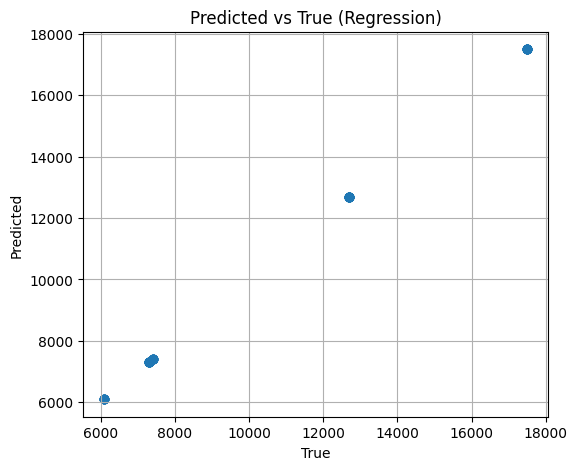

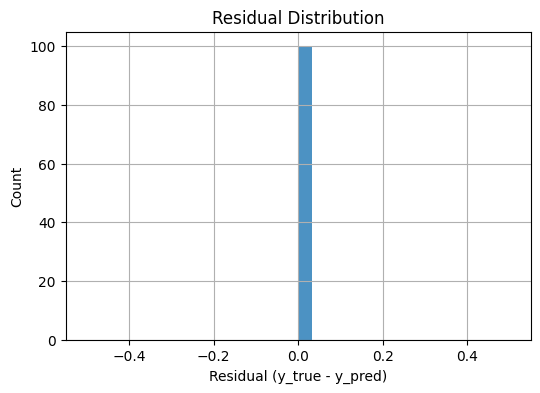

In [8]:
import matplotlib.pyplot as plt

# Predicted vs true
plt.figure(figsize=(6, 5))
plt.scatter(y_test_r, pred, alpha=0.6)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predicted vs True (Regression)")
plt.grid(True)
plt.show()

# Residuals
resid = y_test_r - pred
plt.figure(figsize=(6, 4))
plt.hist(resid, bins=30, alpha=0.8)
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.grid(True)
plt.show()


## 5) Case study C — Clustering for segmentation / discovery

Clustering is commonly used for:

- customer segmentation (marketing personas)
- operational grouping (devices with similar behavior)
- de-duplication and data organization
- exploration when labels are absent

### What clustering can and cannot do

Clustering is not “truth discovery” by default. In real environments you must also:

- validate clusters qualitatively (domain review)
- check stability (do clusters persist across time samples?)
- translate clusters into action (different treatments, monitoring, messaging)

### Distance and scaling

Most clustering methods rely on distances. If features are on different scales, distance is dominated by the largest‑scale feature. Therefore we often standardize:

$$z = \frac{x - \mu}{\sigma}$$

---


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def make_clustering_frame(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a numeric feature matrix from various possible clustering datasets.
    If the dataset is mostly categorical text, we will select a small numeric subset.
    """
    df = df.copy()

    # Try common numeric columns (airports: latitude/longitude/elevation)
    preferred = [c for c in ["latitude_deg", "longitude_deg", "elevation_ft", "Height(Inches)", "Weight(Pounds)"] if c in df.columns]

    if preferred:
        Xc = df[preferred].copy()
    else:
        # Fallback: use any numeric columns
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if not num_cols:
            raise ValueError("No numeric columns available for clustering demo.")
        Xc = df[num_cols].copy()

    # Coerce to numeric, drop missing
    for c in Xc.columns:
        Xc[c] = pd.to_numeric(Xc[c], errors="coerce")
    Xc = Xc.dropna()

    return Xc

Xc = make_clustering_frame(df_clu)
print("Clustering feature matrix shape:", Xc.shape)
display(Xc.head())

# Standardize
Xc_scaled = (Xc - Xc.mean()) / Xc.std(ddof=0)

k = 3 if len(Xc_scaled) >= 20 else 2
kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
labels = kmeans.fit_predict(Xc_scaled)

if len(np.unique(labels)) > 1 and len(Xc_scaled) > k:
    sil = silhouette_score(Xc_scaled, labels)
    print(f"Silhouette score (k={k}): {sil:.3f}")
else:
    print("Silhouette score skipped (insufficient data).")

# Attach labels for inspection
df_clu_labeled = Xc.copy()
df_clu_labeled["cluster"] = labels
display(df_clu_labeled.head(10))

print("Cluster centers (in standardized space):")
display(pd.DataFrame(kmeans.cluster_centers_, columns=Xc.columns))

Clustering feature matrix shape: (6, 3)


,latitude_deg,longitude_deg,elevation_ft
0,40.070985,-74.933689,11
1,38.704022,-101.473911,3435
2,59.947733,-151.692524,450
3,34.864799,-86.770302,820
4,59.093287,-156.456699,80


Silhouette score (k=2): 0.625


,latitude_deg,longitude_deg,elevation_ft,cluster
0,40.070985,-74.933689,11,1
1,38.704022,-101.473911,3435,1
2,59.947733,-151.692524,450,0
3,34.864799,-86.770302,820,1
4,59.093287,-156.456699,80,0
5,34.942803,-97.818019,1100,1


Cluster centers (in standardized space):


,latitude_deg,longitude_deg,elevation_ft
0,1.392069,-1.360043,-0.617790
1,-0.696035,0.680022,0.308895



## 6) Production realities: data leakage, drift, monitoring, and governance

Real-world ML use cases fail most often due to **process** problems rather than algorithms.

### 6.1 Data leakage (the silent performance killer)

Leakage happens when features contain information that would not be available at prediction time.

Common leakage patterns:
- “post-outcome” features (e.g., a flag set after a loan default)
- aggregated features that use future data (improper time windows)
- duplicates across train and test (entity leakage)
- target leakage via preprocessing (fit scalers/encoders on all data)

A simple rule: anything that depends on **future information** relative to the prediction time must be removed or computed in a strictly causal way.

### 6.2 Drift and monitoring

Even if your model is perfect today, the world changes:

- seasonality and trends
- policy changes
- new products
- user behavior changes
- sensor calibration changes

A minimal monitoring plan includes:
- input drift checks (feature distributions)
- prediction drift checks (output distributions)
- performance checks (when ground truth becomes available)

Below is a lightweight “drift demo” using a numeric feature and a Kolmogorov–Smirnov (KS) test. This is a toy illustration; monitoring in production requires robust engineering and alerting policy.

---


Feature chosen for drift demo: Pregnancies
KS(train vs test):        statistic=0.158, p-value=0.0662
KS(train vs drifted):     statistic=0.599, p-value=1.16e-22


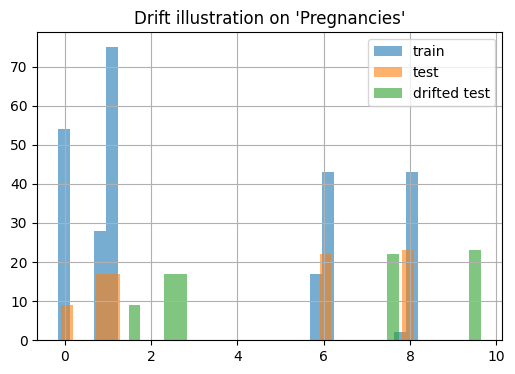

In [10]:
from scipy.stats import ks_2samp

# Pick a numeric feature from the classification dataset (if any) to simulate drift
numeric_cols_cls = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
if numeric_cols_cls:
    feat = numeric_cols_cls[0]
    x_train_feat = pd.to_numeric(X_train[feat], errors="coerce").dropna().values
    x_test_feat = pd.to_numeric(X_test[feat], errors="coerce").dropna().values

    # Simulate drift: shift test distribution slightly
    drifted = x_test_feat + 0.5 * np.std(x_train_feat)

    stat_orig, p_orig = ks_2samp(x_train_feat, x_test_feat)
    stat_drift, p_drift = ks_2samp(x_train_feat, drifted)

    print(f"Feature chosen for drift demo: {feat}")
    print(f"KS(train vs test):        statistic={stat_orig:.3f}, p-value={p_orig:.3g}")
    print(f"KS(train vs drifted):     statistic={stat_drift:.3f}, p-value={p_drift:.3g}")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.hist(x_train_feat, bins=30, alpha=0.6, label="train")
    plt.hist(x_test_feat, bins=30, alpha=0.6, label="test")
    plt.hist(drifted, bins=30, alpha=0.6, label="drifted test")
    plt.title(f"Drift illustration on '{feat}'")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No numeric feature available for drift demo in the selected classification dataset.")


### 6.3 Documentation and governance (why it matters)

In many organizations, a model cannot ship unless it has basic documentation (even for “simple” ML). A practical minimum includes:

- problem statement and intended use
- data sources and update frequency
- feature list and how features are computed
- model type, version, training date, hyperparameters (or training config)
- evaluation protocol and metrics (including slices / subgroups where applicable)
- known limitations and failure modes
- monitoring plan and retraining triggers

This is sometimes called a “model card” or “fact sheet.”

---



## 7) Mini-project prompts (apply to your own domain)

Use the templates below to practice turning a real question into an ML problem.

### Prompt A — Classification use case template
1. Define the decision and the unit (per user? per transaction?).
2. Define the positive class precisely.
3. Define costs: $C_{FP}$ and $C_{FN}$.
4. Pick metrics that reflect your costs (recall, precision, PR AUC, expected cost).
5. List “must-not-use” features to avoid leakage.

### Prompt B — Regression use case template
1. Define what “error” means operationally.
2. Decide whether MAE or RMSE is more aligned with cost.
3. Decide whether you need prediction intervals.
4. Decide acceptable latency and compute footprint.

### Prompt C — Clustering use case template
1. Define what action will change because of clusters.
2. Define what features represent “behavior” vs “identity”.
3. Decide how you will validate clusters (domain review, stability checks).
4. Define what happens if clusters change next month.

---



## Summary

In this lesson you:

- Mapped real-world questions to ML tasks and evaluation frames.
- Built three representative pipelines (classification, regression, clustering) using datasets from the repo.
- Practiced threshold tuning and cost thinking for binary classification.
- Saw a lightweight example of drift detection and why monitoring matters.

Next lessons will deepen the theoretical foundations, but the mental model here—**use case → data → baseline → evaluation → operational constraints**—is what makes ML systems succeed in real environments.
